In [23]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Load the data
df = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv", low_memory=False)

# Filter out rows where family social time response is 'Presented but no response'
df_filtered = df[df['CONNECTION_social_time_family_p7d_grouped'] != 'Presented but no response']

# Sort family social time from least to most
sorted_order = ['No time', 'Less than 1 hour', '1 to 4 hours', '5 or more hours']
df_filtered = df_filtered.copy()
df_filtered['CONNECTION_social_time_family_p7d_grouped'] = pd.Categorical(df_filtered['CONNECTION_social_time_family_p7d_grouped'], categories=sorted_order, ordered=True)
df_filtered = df_filtered.sort_values('CONNECTION_social_time_family_p7d_grouped')

# Extract the relevant columns for analysis
family_social_time = df_filtered['CONNECTION_social_time_family_p7d_grouped']
happiness_score = df_filtered['WELLNESS_subjective_happiness_scale_score']

# Drop any NaN values that may be present
df_filtered = df_filtered[['CONNECTION_social_time_family_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()
family_social_time = df_filtered['CONNECTION_social_time_family_p7d_grouped']
happiness_score = df_filtered['WELLNESS_subjective_happiness_scale_score']

# Bootstrap Sampling
# Set the parameters
reps = 1000  # Number of bootstrap repetitions
sample_size = 500  # Initial sample size for bootstrapping

# Create an array to save the bootstrap means
bootstrapped_means = np.zeros(reps)

# Set a random seed for reproducibility
np.random.seed(130)

# Loop through reps times to create bootstrap samples and calculate sample means
for i in range(reps):
    # Randomly sample from the data (with replacement)
    sample_indices = np.random.choice(family_social_time.index, size=sample_size, replace=True)
    sample_happiness = happiness_score[sample_indices]
    
    # Calculate the mean happiness score of the bootstrap sample and store it
    bootstrapped_means[i] = sample_happiness.mean()

# Plotting the bootstrap distribution
fig = go.Figure()
fig.add_trace(go.Histogram(x=bootstrapped_means, histnorm='probability density', nbinsx=20))
fig.update_layout(
    title='Bootstrap Distribution of Subjective Happiness Scores',
    xaxis_title='Mean Happiness Score',
    yaxis_title='Density',
    bargap=0.1
)
fig.show()

# Confidence Interval Calculation
# Calculate the 95% confidence interval using the percentiles
lower_bound = np.percentile(bootstrapped_means, 2.5)
upper_bound = np.percentile(bootstrapped_means, 97.5)

print(f"95% Confidence Interval for the mean happiness score: ({lower_bound:.2f}, {upper_bound:.2f})")

# Calculate confidence intervals for each family social time group
group_confidence_intervals = {}
for group in sorted_order:
    group_data = df_filtered[df_filtered['CONNECTION_social_time_family_p7d_grouped'] == group]['WELLNESS_subjective_happiness_scale_score']
    boot_means = np.zeros(reps)
    for i in range(reps):
        sample_indices = np.random.choice(group_data.index, size=len(group_data), replace=True)
        sample_happiness = group_data[sample_indices]
        boot_means[i] = sample_happiness.mean()
    lower_ci = np.percentile(boot_means, 2.5)
    upper_ci = np.percentile(boot_means, 97.5)
    group_confidence_intervals[group] = (lower_ci, upper_ci)
    print(f"95% Confidence Interval for {group}: ({lower_ci:.2f}, {upper_ci:.2f})")

# Additional Visualization: Happiness Score Distribution by Family Social Time Groups
fig2 = px.box(
    df_filtered, 
    x='CONNECTION_social_time_family_p7d_grouped', 
    y='WELLNESS_subjective_happiness_scale_score',
    title='Distribution of Subjective Happiness Scores by Family Social Time Group',
    labels={
        'CONNECTION_social_time_family_p7d_grouped': 'Family Social Time Group',
        'WELLNESS_subjective_happiness_scale_score': 'Subjective Happiness Score'
    }
)
fig2.update_layout(
    xaxis_title='Family Social Time Group',
    yaxis_title='Subjective Happiness Score'
)
fig2.show()

# Additional Visualization: Mean Happiness Score by Family Social Time Group with Confidence Intervals
group_means = df_filtered.groupby('CONNECTION_social_time_family_p7d_grouped', observed=True)['WELLNESS_subjective_happiness_scale_score'].mean().reset_index()
group_std = df_filtered.groupby('CONNECTION_social_time_family_p7d_grouped', observed=True)['WELLNESS_subjective_happiness_scale_score'].std().reset_index()

group_means['lower_bound'] = group_means['WELLNESS_subjective_happiness_scale_score'] - 1.96 * (group_std['WELLNESS_subjective_happiness_scale_score'] / np.sqrt(sample_size))
group_means['upper_bound'] = group_means['WELLNESS_subjective_happiness_scale_score'] + 1.96 * (group_std['WELLNESS_subjective_happiness_scale_score'] / np.sqrt(sample_size))

fig3 = go.Figure()
for i, row in group_means.iterrows():
    fig3.add_trace(go.Bar(
        x=[row['CONNECTION_social_time_family_p7d_grouped']],
        y=[row['WELLNESS_subjective_happiness_scale_score']],
        name=row['CONNECTION_social_time_family_p7d_grouped'],
        error_y=dict(
            type='data',
            symmetric=False,
            array=[row['upper_bound'] - row['WELLNESS_subjective_happiness_scale_score']],
            arrayminus=[row['WELLNESS_subjective_happiness_scale_score'] - row['lower_bound']]
        )
    ))

fig3.update_layout(
    title='Mean Subjective Happiness Score by Family Social Time Group with Confidence Intervals',
    xaxis_title='Family Social Time Group',
    yaxis_title='Mean Happiness Score'
)
fig3.show()


95% Confidence Interval for the mean happiness score: (4.34, 4.56)
95% Confidence Interval for No time: (3.91, 4.18)
95% Confidence Interval for Less than 1 hour: (4.17, 4.31)
95% Confidence Interval for 1 to 4 hours: (4.35, 4.49)
95% Confidence Interval for 5 or more hours: (4.70, 4.83)


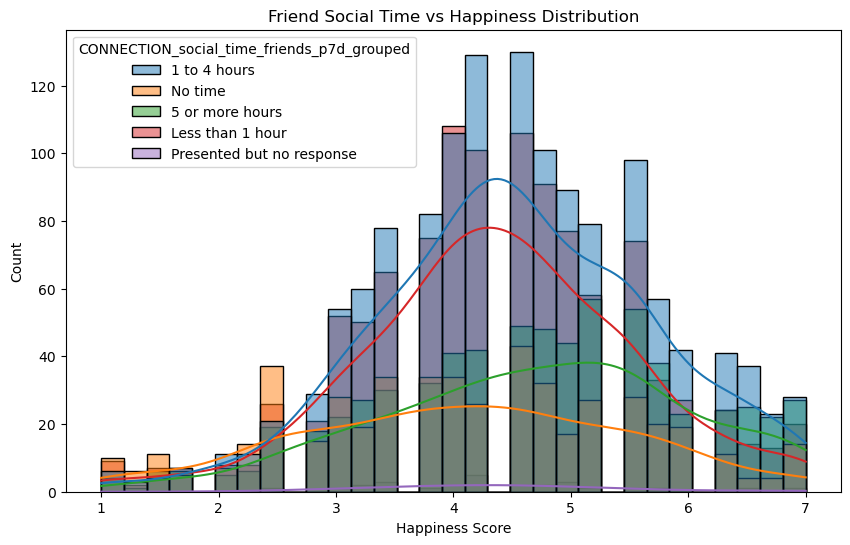

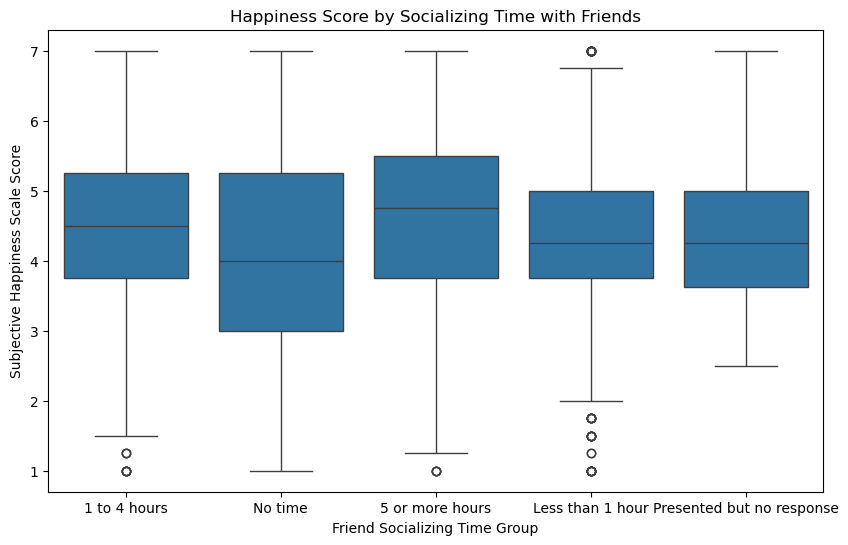


P-values for each friend socialising time group:
{'1 to 4 hours': 0.514, '5 or more hours': 0.527, 'Less than 1 hour': 0.501, 'No time': 0.481, 'Presented but no response': 0.504}


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv', low_memory=False)

# Filter relevant columns
friends_data = data[['CONNECTION_social_time_friends_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()

# Convert categorical variable into numerical values
label_encoder = LabelEncoder()
friends_data['social_time_encoded'] = label_encoder.fit_transform(friends_data['CONNECTION_social_time_friends_p7d_grouped'])

# Data visualization
plt.figure(figsize=(10, 6))
sns.histplot(friends_data, x='WELLNESS_subjective_happiness_scale_score', hue='CONNECTION_social_time_friends_p7d_grouped', kde=True)
plt.xlabel('Happiness Score')
plt.title('Friend Social Time vs Happiness Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=friends_data, x='CONNECTION_social_time_friends_p7d_grouped', y='WELLNESS_subjective_happiness_scale_score')
plt.xlabel('Friend Socializing Time Group')
plt.ylabel('Subjective Happiness Scale Score')
plt.title('Happiness Score by Socializing Time with Friends')
plt.show()

# Perform bootstrapping for hypothesis testing
n_iterations = 1000
observed_means = friends_data.groupby('CONNECTION_social_time_friends_p7d_grouped')['WELLNESS_subjective_happiness_scale_score'].mean()

bootstrap_means = []

for i in range(n_iterations):
    bootstrap_sample = friends_data.sample(frac=1, replace=True)
    bootstrap_group_means = bootstrap_sample.groupby('CONNECTION_social_time_friends_p7d_grouped')['WELLNESS_subjective_happiness_scale_score'].mean()
    bootstrap_means.append(bootstrap_group_means)

# Test statistics
p_values = {}
for group in observed_means.index:
    greater_count = sum([bm[group] > observed_means[group] for bm in bootstrap_means])
    p_values[group] = greater_count / n_iterations

print("\nP-values for each friend socialising time group:")
print(p_values)



Classification Tree for Friends Social Time:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       571
           1       0.58      0.22      0.32       509

    accuracy                           0.56      1080
   macro avg       0.57      0.54      0.50      1080
weighted avg       0.57      0.56      0.51      1080

Accuracy Score: 0.5574074074074075


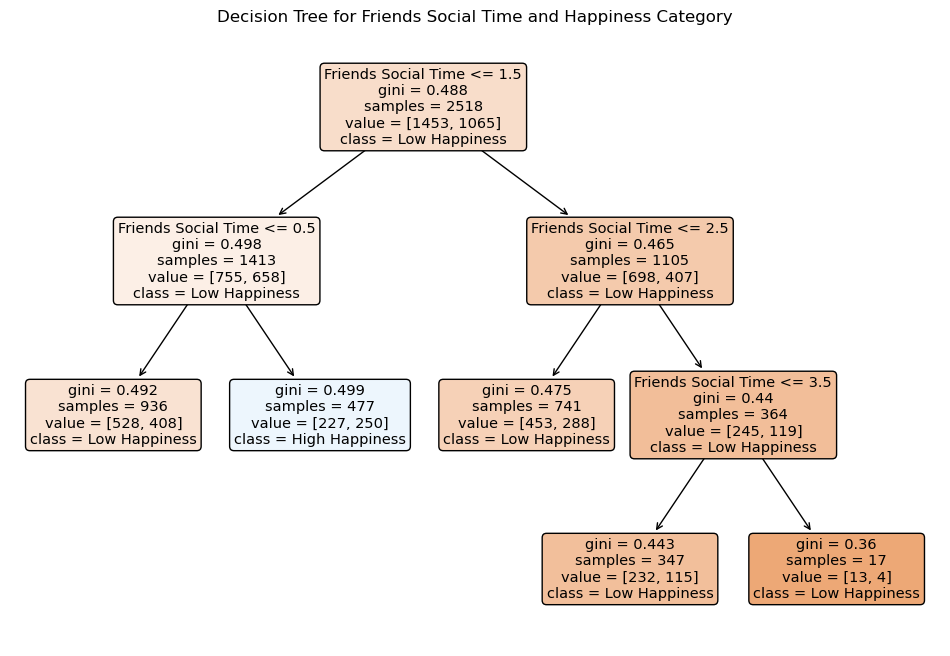

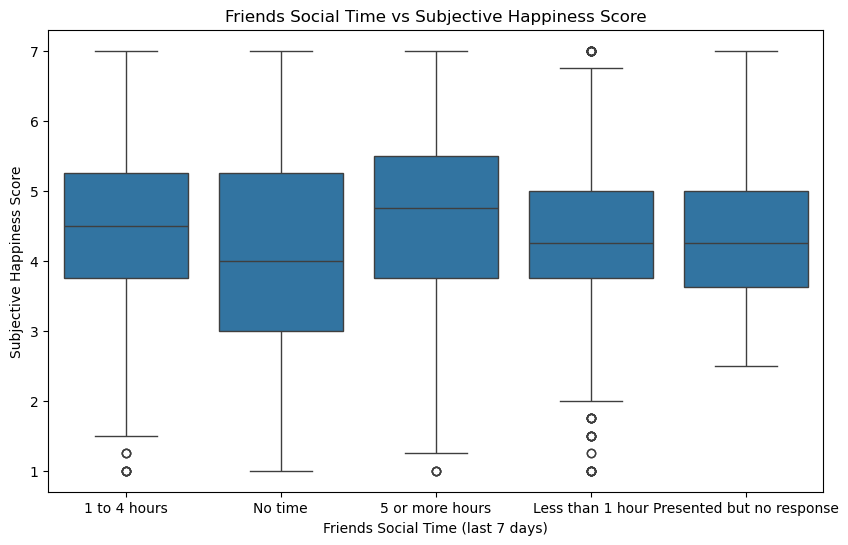

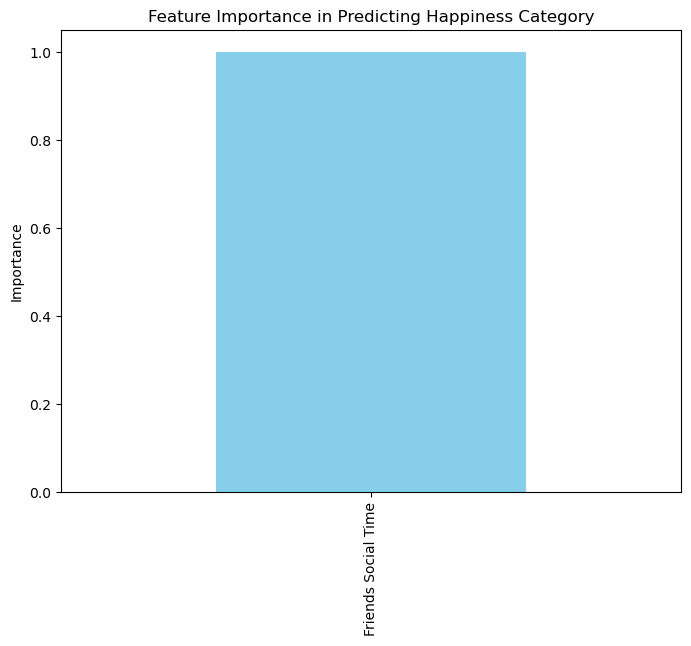

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv', low_memory=False)

# Filter relevant columns
friends_data = data[['CONNECTION_social_time_friends_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()

# Convert categorical variable into numerical values
label_encoder = LabelEncoder()
friends_data['social_time_encoded'] = label_encoder.fit_transform(friends_data['CONNECTION_social_time_friends_p7d_grouped'])

# Add a classification tree
threshold = friends_data['WELLNESS_subjective_happiness_scale_score'].median()
friends_data['happiness_category'] = (friends_data['WELLNESS_subjective_happiness_scale_score'] > threshold).astype(int)

X = friends_data[['social_time_encoded']].values  # Use the encoded column for training
y = friends_data['happiness_category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\nClassification Tree for Friends Social Time:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['Friends Social Time'], class_names=['Low Happiness', 'High Happiness'], filled=True, rounded=True) 
plt.title("Decision Tree for Friends Social Time and Happiness Category") 
plt.show()

# Step 4: Additional visualization
# Visualize the relationship between social time with friends and subjective happiness
plt.figure(figsize=(10, 6))
sns.boxplot(x='CONNECTION_social_time_friends_p7d_grouped', y='WELLNESS_subjective_happiness_scale_score', data=friends_data)
plt.xlabel('Friends Social Time (last 7 days)')
plt.ylabel('Subjective Happiness Score')
plt.title('Friends Social Time vs Subjective Happiness Score')
plt.show()

# Visualize feature importance
feature_importance = pd.Series(clf.feature_importances_, index=['Friends Social Time'])
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.ylabel('Importance')
plt.title('Feature Importance in Predicting Happiness Category')
plt.show()
